In [ ]:
import os

# Подивимось на структуру папок датасету
data_path = "/kaggle/input"

for dirname, _, filenames in os.walk(data_path):
    # Показуємо тільки назви папок (класи), не всі файли
    level = dirname.replace(data_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(dirname)}/')
    if level >= 2:  # не заглиблюємось далі 2 рівнів
        continue

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn as nn

# Трансформації для тренувальних даних (з аугментацією)
# Посилання: https://pytorch.org/vision/stable/transforms.html
# Навіщо це потрібно: нейромережа вчиться краще, коли бачить більше різноманітних прикладів.
# Без аугментації вона може "завчити" конкретні фото замість того,
# щоб зрозуміти загальні ознаки фрукта.
# Аугментація — це коли ти штучно "розмножуєш" свої фотографії, трохи змінюючи кожну.
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Шлях до даних (тільки train — там є підпапки з класами)
train_path = "/kaggle/input/datasets/sshikamaru/fruit-recognition/train/train/"

# GPU пристрій
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Пристрій: {device}")

In [ ]:
# Розбиття (як на уроці)
# Повний датасет з двома варіантами трансформацій
full_dataset = datasets.ImageFolder(train_path, transform=train_transform)
full_dataset_test = datasets.ImageFolder(train_path, transform=test_transform)

# Фіксуємо seed для однакового розбиття (однаково для PyTorch і TensorFlow!)
torch.manual_seed(42)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Генеруємо індекси один раз для усіх 4 варіантів
indices = torch.randperm(len(full_dataset)).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Train — з аугментацією, Test — без аугментації
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset_test, test_indices)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Параметри
input_size = 3 * 224 * 224  # 150528
num_classes = len(full_dataset.classes)

print(f"Тренувальних: {len(train_dataset)}")
print(f"Тестових: {len(test_dataset)}")

# Назви класів (фруктів)
print(f"Кількість класів: {len(full_dataset.classes)}")
print(f"Класи: {full_dataset.classes}")
print(f"\nclass_to_idx: {full_dataset.class_to_idx}")

print(f"Розмір входу: {input_size}")

In [ ]:
# Подивимось на перший зразок
img, label = full_dataset[0]
print(f"Тип: {type(img)}")
print(f"Форма тензора: {img.shape}")  # [C, H, W] = [3, 224, 224]
print(f"Мітка (індекс): {label}")
print(f"Назва класу: {full_dataset.classes[label]}")

# Перший зразок з кожного класу (до 5 класів)
shown_classes = set()
for i in range(len(full_dataset)):
    img, label = full_dataset[i]
    if label not in shown_classes:
        print(f"Зразок [{i}]: форма {img.shape}, мітка: {label} → {full_dataset.classes[label]}")
        shown_classes.add(label)
    if len(shown_classes) >= 5:
        break

In [ ]:

# Візуалізація - Перевірка
for images, labels in train_loader:
    print(f"Форма батчу зображень: {images.shape}")  # [batch_size, 3, 224, 224]
    print(f"Форма батчу міток: {labels.shape}")       # [batch_size]
    break  # Виводимо тільки перший батч

In [ ]:
# Візуалізація кількох зразків з тренувального набору
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    # Конвертуємо тензор [C, H, W] → [H, W, C] для matplotlib
    img_np = img.permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(full_dataset.classes[label])
    ax.axis('off')

plt.suptitle("Зразки з тренувального датасету", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Отримуємо один батч
images, labels = next(iter(train_loader))

# Створюємо сітку зображень
grid = make_grid(images[:16], nrow=4, padding=2)

# Відображаємо
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.title("Батч зображень з тренувального DataLoader")
plt.axis('off')
plt.show()

# Виводимо мітки
print("Мітки:", [full_dataset.classes[l] for l in labels[:16].tolist()])

In [ ]:
# Fruit Classification — 4 варіанти нейромережі

# Вхід:       3 × 224 × 224 = 150528
# Flatten:    [batch, 150528]
# Linear/Dense 1:  150528 → 512  + activation
# Linear/Dense 2:  512 → 256     + activation
# Linear/Dense 3:  256 → 128     + activation
# Linear/Dense 4:  128 → num_classes (вихід)

# Параметри
input_size = 3 * 224 * 224  # 150528
num_classes = len(full_dataset.classes)

print(f"Тренувальних: {len(train_dataset)}")
print(f"Тестових: {len(test_dataset)}")

# Назви класів (фруктів)
print(f"Кількість класів: {len(full_dataset.classes)}")
print(f"Класи: {full_dataset.classes}")
print(f"\nclass_to_idx: {full_dataset.class_to_idx}")

print(f"Розмір входу: {input_size}")

In [ ]:
 # Варіант 1: PyTorch + ReLU

class FruitNet_ReLU(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                         # Шар 1: → [batch, 150528]
            nn.Linear(input_size, 512),            # Шар 2: 150528 → 512
            nn.ReLU(),
            nn.Linear(512, 256),                   # Шар 3: 512 → 256
            nn.ReLU(),
            nn.Linear(256, 128),                   # Шар 4: 256 → 128
            nn.ReLU(),
            nn.Linear(128, num_classes),            # Шар 5: 128 → num_classes
        )

    def forward(self, x):
        return self.model(x)

model_relu = FruitNet_ReLU(input_size, num_classes).to(device)
print("=== PyTorch + ReLU ===")
print(model_relu)

In [ ]:
 # Варіант 2: PyTorch + LeakyReLU

class FruitNet_LeakyReLU(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),                         # Шар 1: → [batch, 150528]
            nn.Linear(input_size, 512),            # Шар 2: 150528 → 512
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),                   # Шар 3: 512 → 256
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),                   # Шар 4: 256 → 128
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, num_classes),            # Шар 5: 128 → num_classes
        )

    def forward(self, x):
        return self.model(x)

model_leaky = FruitNet_LeakyReLU(input_size, num_classes).to(device)

print("=== PyTorch + LeakyReLU ===")
print(model_leaky)

In [ ]:
# Перевірка обох моделей PyTorch

# тут потрібен .to(device)
images, labels = next(iter(train_loader))
images = images.to(device)          # ← бо модель на GPU

output_relu = model_relu(images)     # модель на GPU, дані теж на GPU
output_leaky = model_leaky(images)

print(f"Вхід:             {images.shape}")
print(f"Вихід ReLU:       {output_relu.shape}")
print(f"Вихід LeakyReLU:  {output_leaky.shape}")

# Кількість параметрів
def count_params(model):
    return sum(p.numel() for p in model.parameters())

print(f"\nПараметрів ReLU:      {count_params(model_relu):,}")
print(f"Параметрів LeakyReLU: {count_params(model_leaky):,}")

In [ ]:
# TensorFlow / Keras
# Імпорт та дані (TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Завантаження з того ж train_path, розбиття 80/20 з seed=42
train_tf = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=42,
)

test_tf = tf.keras.utils.image_dataset_from_directory(
    train_path,          # ← теж train_path!
    image_size=(224, 224),
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=42,
)

# Зберігаємо class_names ДО нормалізації (після .map() вони зникають)
class_names_tf = train_tf.class_names
num_classes_tf = len(class_names_tf)

# Нормалізація [0, 255] → [0, 1]
normalization = layers.Rescaling(1./255)
train_tf = train_tf.map(lambda x, y: (normalization(x), y))
test_tf = test_tf.map(lambda x, y: (normalization(x), y))

# Параметри
input_shape = (224, 224, 3)
print(f"Класи: {class_names_tf}")
print(f"Кількість класів: {num_classes_tf}")

In [ ]:
# Варіант 3: TensorFlow + ReLU
# model_tf_relu = keras.Sequential([
#     layers.Flatten(input_shape=input_shape, name='flatten'),      # Шар 1
#     layers.Dense(512, activation='relu', name='dense_1'),          # Шар 2: 150528 → 512
#     layers.Dense(256, activation='relu', name='dense_2'),          # Шар 3: 512 → 256
#     layers.Dense(128, activation='relu', name='dense_3'),          # Шар 4: 256 → 128
#     layers.Dense(num_classes, activation='softmax', name='output') # Шар 5: 128 → num_classes
# ], name='FruitNet_ReLU')

model_tf_relu = keras.Sequential([
    layers.Input(shape=input_shape),                               # ← новий спосіб
    layers.Flatten(name='flatten'),                                # без input_shape
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(256, activation='relu', name='dense_2'),
    layers.Dense(128, activation='relu', name='dense_3'),
    layers.Dense(num_classes_tf, activation='softmax', name='output')
], name='FruitNet_ReLU')

model_tf_relu.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== TensorFlow + ReLU ===")
model_tf_relu.summary()

In [ ]:
# Варіант 4: TensorFlow + LeakyReLU
# # Старий спосіб:
# model_tf_leaky = keras.Sequential([
#     layers.Flatten(input_shape=input_shape, name='flatten'),
#     layers.Dense(512, name='dense_1'),
#     layers.LeakyReLU(negative_slope=0.01, name='leaky_1'),
#     ...
# ], name='FruitNet_LeakyReLU')

# Новий спосіб:
model_tf_leaky = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(name='flatten'),
    layers.Dense(512, name='dense_1'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_1'),
    layers.Dense(256, name='dense_2'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_2'),
    layers.Dense(128, name='dense_3'),
    layers.LeakyReLU(negative_slope=0.01, name='leaky_3'),
    layers.Dense(num_classes_tf, activation='softmax', name='output'),
], name='FruitNet_LeakyReLU')

model_tf_leaky.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== TensorFlow + LeakyReLU ===")
model_tf_leaky.summary()

In [ ]:
 # Перевірка обох моделей TensorFlow

for images, labels in train_tf.take(1):
    output_relu = model_tf_relu(images)
    output_leaky = model_tf_leaky(images)

    print(f"Вхід:             {images.shape}")
    print(f"Вихід ReLU:       {output_relu.shape}")
    print(f"Вихід LeakyReLU:  {output_leaky.shape}")

print(f"\nПараметрів ReLU:      {model_tf_relu.count_params():,}")
print(f"Параметрів LeakyReLU: {model_tf_leaky.count_params():,}")

In [ ]:
# Тренування PyTorch + ReLU
import time

# Налаштування
criterion = nn.CrossEntropyLoss()
optimizer_relu = torch.optim.Adam(model_relu.parameters(), lr=0.001)
epochs = 10

# Списки для збереження метрик
train_losses_relu = []
train_accs_relu = []

print("=== Тренування: PyTorch + ReLU ===")
start_time = time.time()

for epoch in range(epochs):
    model_relu.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_relu(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer_relu.zero_grad()
        loss.backward()
        optimizer_relu.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses_relu.append(epoch_loss)
    train_accs_relu.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

relu_time = time.time() - start_time
print(f"\nЧас тренування ReLU: {relu_time:.1f} сек")

###=== Тренування: PyTorch + ReLU ===
    Epoch [1/10] Loss: 1.4112 Accuracy: 0.6381
    Epoch [2/10] Loss: 0.2531 Accuracy: 0.9154
    Epoch [3/10] Loss: 0.1931 Accuracy: 0.9366
    Epoch [4/10] Loss: 0.1199 Accuracy: 0.9601
    Epoch [5/10] Loss: 0.1377 Accuracy: 0.9546
    Epoch [6/10] Loss: 0.1204 Accuracy: 0.9581
    Epoch [7/10] Loss: 0.1243 Accuracy: 0.9617
    Epoch [8/10] Loss: 0.1560 Accuracy: 0.9548
    Epoch [9/10] Loss: 0.0765 Accuracy: 0.9721
    Epoch [10/10] Loss: 0.0549 Accuracy: 0.9822

In [ ]:
# Тренування PyTorch + LeakyReLU
optimizer_leaky = torch.optim.Adam(model_leaky.parameters(), lr=0.001)

train_losses_leaky = []
train_accs_leaky = []

print("=== Тренування: PyTorch + LeakyReLU ===")
start_time = time.time()

for epoch in range(epochs):
    model_leaky.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_leaky(images)
        loss = criterion(outputs, labels)

        optimizer_leaky.zero_grad()
        loss.backward()
        optimizer_leaky.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses_leaky.append(epoch_loss)
    train_accs_leaky.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

leaky_time = time.time() - start_time
print(f"\nЧас тренування LeakyReLU: {leaky_time:.1f} сек")

### === Тренування: PyTorch + LeakyReLU ===
    Epoch [1/10] Loss: 1.5527 Accuracy: 0.6045
    Epoch [2/10] Loss: 0.2844 Accuracy: 0.9034
    Epoch [3/10] Loss: 0.1715 Accuracy: 0.9420
    Epoch [4/10] Loss: 0.2013 Accuracy: 0.9334
    Epoch [5/10] Loss: 0.1400 Accuracy: 0.9559
    Epoch [6/10] Loss: 0.1191 Accuracy: 0.9618
    Epoch [7/10] Loss: 0.1402 Accuracy: 0.9587
    Epoch [8/10] Loss: 0.1171 Accuracy: 0.9640
    Epoch [9/10] Loss: 0.0529 Accuracy: 0.9828
    Epoch [10/10] Loss: 0.1785 Accuracy: 0.9540

    Час тренування LeakyReLU: 408.5 сек

In [ ]:
# Тестування PyTorch (обидва варіанти)
def test_pytorch_model(model, test_loader, device, name):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"{name}: Test Loss: {avg_loss:.4f}, Test Accuracy: {acc:.4f} ({correct}/{total})")
    return avg_loss, acc

print("=== Тестування PyTorch ===")
pt_relu_loss, pt_relu_acc = test_pytorch_model(model_relu, test_loader, device, "ReLU")
pt_leaky_loss, pt_leaky_acc = test_pytorch_model(model_leaky, test_loader, device, "LeakyReLU")

### === Тестування PyTorch ===
    ReLU: Test Loss: 0.0360, Test Accuracy: 0.9861 (3324/3371)
    LeakyReLU: Test Loss: 0.0306, Test Accuracy: 0.9896 (3336/3371)

In [ ]:
# Аналіз мертвих нейронів
def count_dead_neurons(model, data_loader, device, name):
    """Рахуємо нейрони які видають 0 на ВСІХ зразках"""
    model.eval()
    
    # Збираємо активації після кожного ReLU/LeakyReLU
    activations = {}
    
    def hook_fn(layer_name):
        def hook(module, input, output):
            if layer_name not in activations:
                activations[layer_name] = []
            activations[layer_name].append((output > 0).float().cpu())
        return hook
    
    # Реєструємо hooks на activation шари
    hooks = []
    for layer_name, module in model.model.named_modules():
        if isinstance(module, (nn.ReLU, nn.LeakyReLU)):
            hooks.append(module.register_forward_hook(hook_fn(layer_name)))
    
    # Прогоняємо дані
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            _ = model(images)
    
    # Видаляємо hooks
    for h in hooks:
        h.remove()
    
    # Аналізуємо: нейрон "мертвий" якщо він = 0 для ВСІХ зразків
    print(f"\n=== Мертві нейрони: {name} ===")
    dead_counts = {}
    total_counts = {}
    
    for layer_name, acts in activations.items():
        combined = torch.cat(acts, dim=0)            # [всі зразки, нейрони]
        alive_ratio = combined.mean(dim=0)            # частка активних для кожного нейрона
        dead = (alive_ratio == 0).sum().item()        # нейрон мертвий = 0% активацій
        total = combined.shape[1]
        dead_counts[layer_name] = dead
        total_counts[layer_name] = total
        print(f"  Шар {layer_name}: {dead}/{total} мертвих ({100*dead/total:.1f}%)")
    
    return dead_counts, total_counts

relu_dead, relu_total = count_dead_neurons(model_relu, test_loader, device, "PyTorch + ReLU")
leaky_dead, leaky_total = count_dead_neurons(model_leaky, test_loader, device, "PyTorch + LeakyReLU")

# Графік
fig, ax = plt.subplots(figsize=(10, 5))

layers_names = [f"Layer {i+1}\n({relu_total[k]} нейронів)" for i, k in enumerate(relu_dead.keys())]
x = range(len(layers_names))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], relu_dead.values(), width, label='ReLU (мертві)', color='tomato')
bars2 = ax.bar([i + width/2 for i in x], leaky_dead.values(), width, label='LeakyReLU (мертві)', color='skyblue')

# Підписи на стовпцях
for bar in bars1:
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1, 
                f'{int(bar.get_height())}', ha='center', fontweight='bold')
for bar in bars2:
    if bar.get_height() > 0:
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{int(bar.get_height())}', ha='center', fontweight='bold')

ax.set_xlabel('Шар')
ax.set_ylabel('Кількість мертвих нейронів')
ax.set_title('Мертві нейрони: ReLU vs LeakyReLU')
ax.set_xticks(x)
ax.set_xticklabels(layers_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### === Мертві нейрони: PyTorch + ReLU ===
      Шар 2: 470/512 мертвих (91.8%)
      Шар 4: 179/256 мертвих (69.9%)
      Шар 6: 51/128 мертвих (39.8%)

### === Мертві нейрони: PyTorch + LeakyReLU ===
      Шар 2: 446/512 мертвих (87.1%)
      Шар 4: 152/256 мертвих (59.4%)
      Шар 6: 60/128 мертвих (46.9%)

[https://drive.google.com/file/d/15fZQKqhQ6AOX6v7OaPVYtKuEWx-MOkjp/view?usp=sharing](http://)

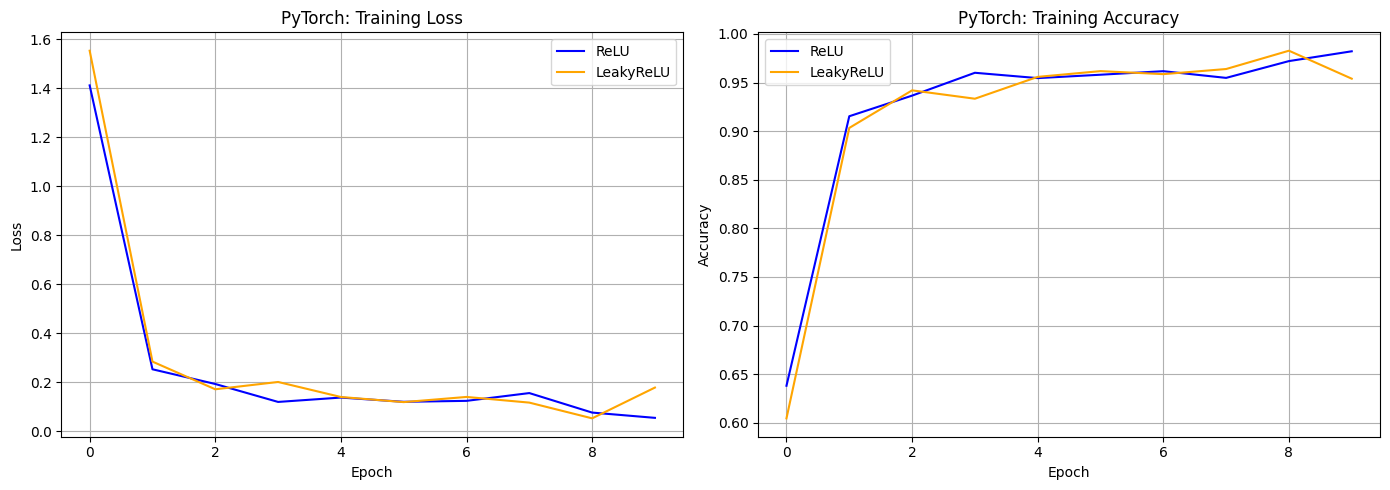

In [27]:
# Графіки PyTorch
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(train_losses_relu, label='ReLU', color='blue')
ax1.plot(train_losses_leaky, label='LeakyReLU', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('PyTorch: Training Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(train_accs_relu, label='ReLU', color='blue')
ax2.plot(train_accs_leaky, label='LeakyReLU', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('PyTorch: Training Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [29]:
# Тренування TensorFlow (обидва варіанти)
# Тренування TensorFlow + ReLU
print("=== Тренування: TensorFlow + ReLU ===")
start_time = time.time()

history_tf_relu = model_tf_relu.fit(
    train_tf,
    validation_data=test_tf,
    epochs=10,
    verbose=1
)

tf_relu_time = time.time() - start_time
print(f"\nЧас тренування TF ReLU: {tf_relu_time:.1f} сек")

=== Тренування: TensorFlow + ReLU ===
Epoch 1/10


I0000 00:00:1771665090.663281     342 service.cc:152] XLA service 0x7af05800dd50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771665090.663342     342 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1771665091.148862     342 cuda_dnn.cc:529] Loaded cuDNN version 91002


 11/422 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0231 - loss: 90.6868

I0000 00:00:1771665092.466022     342 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3874 - loss: 20.4150 - val_accuracy: 0.8973 - val_loss: 0.2825
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9414 - loss: 0.2089 - val_accuracy: 0.8519 - val_loss: 0.4454
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8877 - loss: 0.4225 - val_accuracy: 0.9816 - val_loss: 0.0713
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9679 - loss: 0.1149 - val_accuracy: 0.8697 - val_loss: 0.5246
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9507 - loss: 0.1917 - val_accuracy: 0.9902 - val_loss: 0.0325
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9390 - loss: 0.3049 - val_accuracy: 0.9843 - val_loss: 0.0389
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9570 - loss: 0.1818 - val_accuracy: 0.9929 - val_loss: 0.0248
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9629 - loss: 0.1495 - val_accuracy: 0.9

422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3874 - loss: 20.4150 - val_accuracy: 0.8973 - val_loss: 0.2825
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9414 - loss: 0.2089 - val_accuracy: 0.8519 - val_loss: 0.4454
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8877 - loss: 0.4225 - val_accuracy: 0.9816 - val_loss: 0.0713
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9679 - loss: 0.1149 - val_accuracy: 0.8697 - val_loss: 0.5246
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9507 - loss: 0.1917 - val_accuracy: 0.9902 - val_loss: 0.0325
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9390 - loss: 0.3049 - val_accuracy: 0.9843 - val_loss: 0.0389
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9570 - loss: 0.1818 - val_accuracy: 0.9929 - val_loss: 0.0248
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9629 - loss: 0.1495 - val_accuracy: 0.9496 - val_loss: 0.1536
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9609 - loss: 0.1721 - val_accuracy: 0.9970 - val_loss: 0.0074
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9920 - loss: 0.0349 - val_accuracy: 0.9680 - val_loss: 0.1169

Час тренування TF ReLU: 98.2 сек

422/422 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.3874 - loss: 20.4150 - val_accuracy: 0.8973 - val_loss: 0.2825
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9414 - loss: 0.2089 - val_accuracy: 0.8519 - val_loss: 0.4454
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8877 - loss: 0.4225 - val_accuracy: 0.9816 - val_loss: 0.0713
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9679 - loss: 0.1149 - val_accuracy: 0.8697 - val_loss: 0.5246
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9507 - loss: 0.1917 - val_accuracy: 0.9902 - val_loss: 0.0325
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9390 - loss: 0.3049 - val_accuracy: 0.9843 - val_loss: 0.0389
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9570 - loss: 0.1818 - val_accuracy: 0.9929 - val_loss: 0.0248
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9629 - loss: 0.1495 - val_accuracy: 0.9496 - val_loss: 0.1536
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9609 - loss: 0.1721 - val_accuracy: 0.9970 - val_loss: 0.0074
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9920 - loss: 0.0349 - val_accuracy: 0.9680 - val_loss: 0.1169

Час тренування TF ReLU: 98.2 сек

In [30]:
# Тренування TensorFlow + LeakyReLU
print("=== Тренування: TensorFlow + LeakyReLU ===")
start_time = time.time()

history_tf_leaky = model_tf_leaky.fit(
    train_tf,
    validation_data=test_tf,
    epochs=10,
    verbose=1
)

tf_leaky_time = time.time() - start_time
print(f"\nЧас тренування TF LeakyReLU: {tf_leaky_time:.1f} сек")

=== Тренування: TensorFlow + LeakyReLU ===
Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.3975 - loss: 22.2341 - val_accuracy: 0.9567 - val_loss: 0.1571
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9317 - loss: 0.2350 - val_accuracy: 0.9929 - val_loss: 0.0344
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9511 - loss: 0.1815 - val_accuracy: 0.9128 - val_loss: 0.3129
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9495 - loss: 0.1705 - val_accuracy: 0.9967 - val_loss: 0.0135
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9778 - loss: 0.0829 - val_accuracy: 0.9774 - val_loss: 0.0638
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.9475 - loss: 0.2821 - val_accuracy: 0.9119 - val_loss: 0.3887
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.9617 - loss: 0.1684 - val_accuracy: 0.9421 - val_loss: 0.2837
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step